<a href="https://colab.research.google.com/github/Barissdal/Churn-Analysis-with-Under-Sampling/blob/main/Telco_Dataset_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [3]:
!pip install skompiler

     |████████████████████████████████| 45 kB 3.8 MB/s 
  Created wheel for skompiler: filename=SKompiler-0.6-py3-none-any.whl size=54286 sha256=c4a72d59c85f8b9d2ed53aee9583d678fbdb592ad14a161665299ecbc4f81d63
  Stored in directory: /root/.cache/pip/wheels/47/1c/59/b80a730f4afd2144bad854df4b167b812486c9d4c1bd4cf4c5
Successfully built skompiler


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from catboost import CatBoostClassifier
import missingno as msno
from datetime import date
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict,ShuffleSplit,GridSearchCV
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,scale, RobustScaler,LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score, roc_auc_score,roc_curve, classification_report,mean_squared_error,f1_score,recall_score,precision_score
from sklearn.neighbors import KNeighborsClassifier,LocalOutlierFactor 
from sklearn.ensemble import RandomForestClassifier,BaseEnsemble,GradientBoostingClassifier,IsolationForest
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB
import time
from xgboost import XGBClassifier
from skompiler import skompile
from lightgbm import LGBMClassifier
from joblib import dump, load

In [5]:
df_ = pd.read_csv("/content/drive/MyDrive/resource/telco.csv")

In [6]:
df = df_.copy()
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
#TotalCharges convert to numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors='coerce')

In [8]:
#Churn convert to binary
df["Churn"] = df["Churn"].apply(lambda x : 1 if x == "Yes" else 0)

In [9]:
#All Columns' name upper
df.columns = [col.upper() for col in df.columns]

In [10]:
#Show dtype of variables with function

def grab_col_names(dataframe, cat_th=10, car_th=20):

    
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
  
    return cat_cols, num_cols, cat_but_car

In [11]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

In [ ]:
cat_cols

['GENDER',
 'PARTNER',
 'DEPENDENTS',
 'PHONESERVICE',
 'MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAPERLESSBILLING',
 'PAYMENTMETHOD',
 'SENIORCITIZEN',
 'CHURN']

In [ ]:
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES']

In [ ]:
cat_but_car

['CUSTOMERID']

In [12]:
# describe a function for plot

def cat_analyser_plot(df, cat_col, target_col):  
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
      
    df[cat_col].value_counts().plot(kind='bar', ax=axes[0], color=['#C70C03', '#A0C703', '#C78303', '#C74103'])
    axes[0].set_title(f"{cat_col}"+" "+"Dağılımı")
    axes[0].set_xlabel(f"{cat_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    df.groupby(cat_col)[target_col].mean().plot(kind='bar', ax=axes[1], color=['#C70C03', '#A0C703', '#C78303', '#A0C703'] )
    axes[1].set_title(f"{cat_col}"+" "+" Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{cat_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.show()

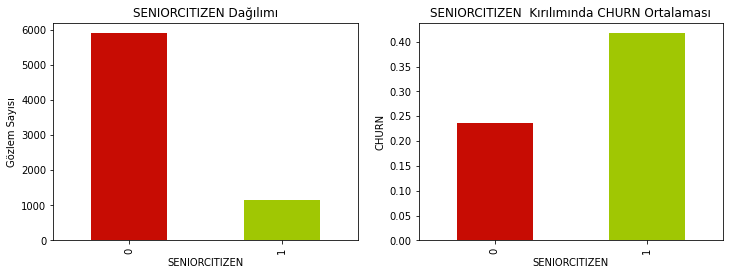

In [ ]:
cat_analyser_plot(df,"SENIORCITIZEN","CHURN")

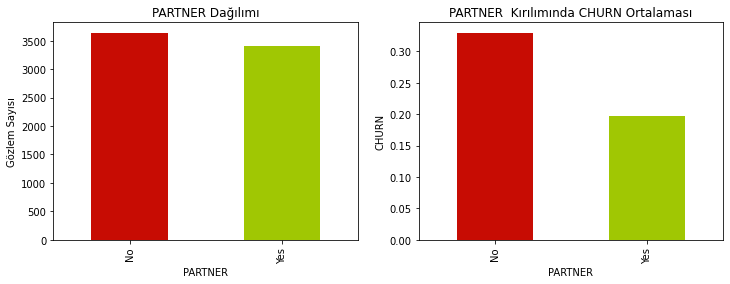

In [ ]:
cat_analyser_plot(df,"PARTNER","CHURN")

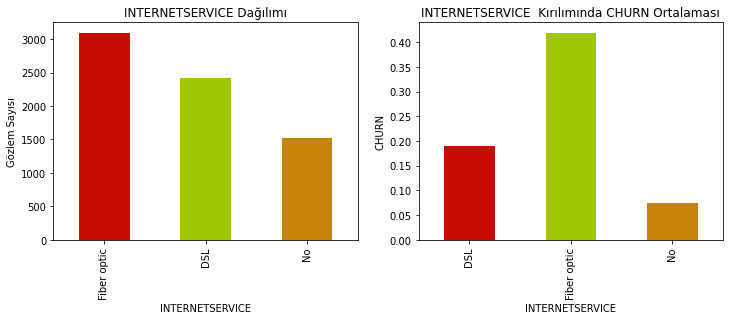

In [ ]:
cat_analyser_plot(df,"INTERNETSERVICE","CHURN")

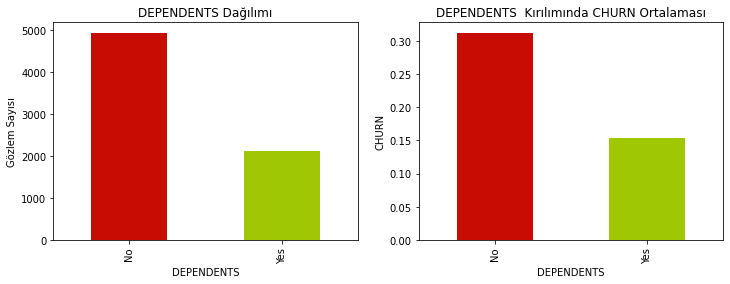

In [ ]:
cat_analyser_plot(df,"DEPENDENTS","CHURN")

In [ ]:
# num_cols
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES']

In [13]:
def num_analyser_plot(df, num_col, target_col):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    df[num_col].hist(bins=20, ax=axes[0])
    axes[0].set_title(f"{num_col}"+" "+"Dağılımı")
    axes[0].set_xlabel(f"{num_col}")
    axes[0].set_ylabel("Gözlem Sayısı")
    
    quantiles = [0, 0.25, 0.50, 0.75, 1]
    num_df = df.copy()
    num_df[f"{num_col}"+"_CAT"] = pd.qcut(df[num_col], q=quantiles) 
    
    num_df.groupby(f"{num_col}"+"_CAT")[target_col].mean().plot(kind='bar', ax=axes[1], color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    axes[1].set_title(f"{num_col}"+" "+" Kırılımında"+" "+f"{target_col}"+" "+ "Ortalaması")
    axes[1].set_xlabel(f"{num_col}")
    axes[1].set_ylabel(f"{target_col}")
    plt.xticks(rotation=0)
    plt.show()

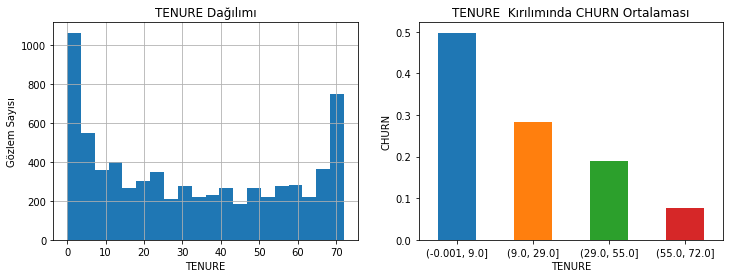

In [ ]:
num_analyser_plot(df, "TENURE", "CHURN")

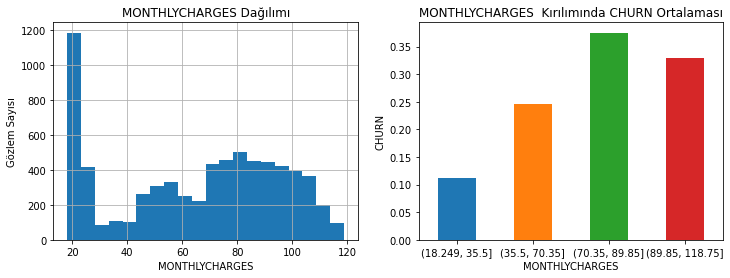

In [ ]:
num_analyser_plot(df, "MONTHLYCHARGES", "CHURN")

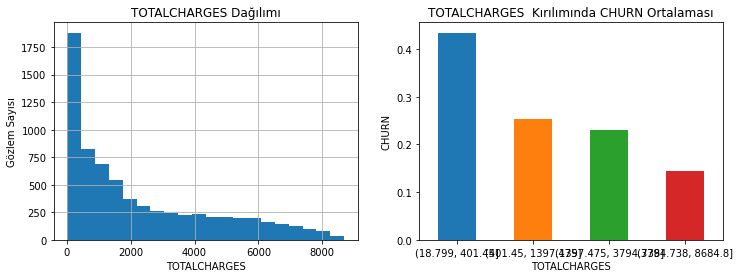

In [ ]:
num_analyser_plot(df, "TOTALCHARGES", "CHURN")

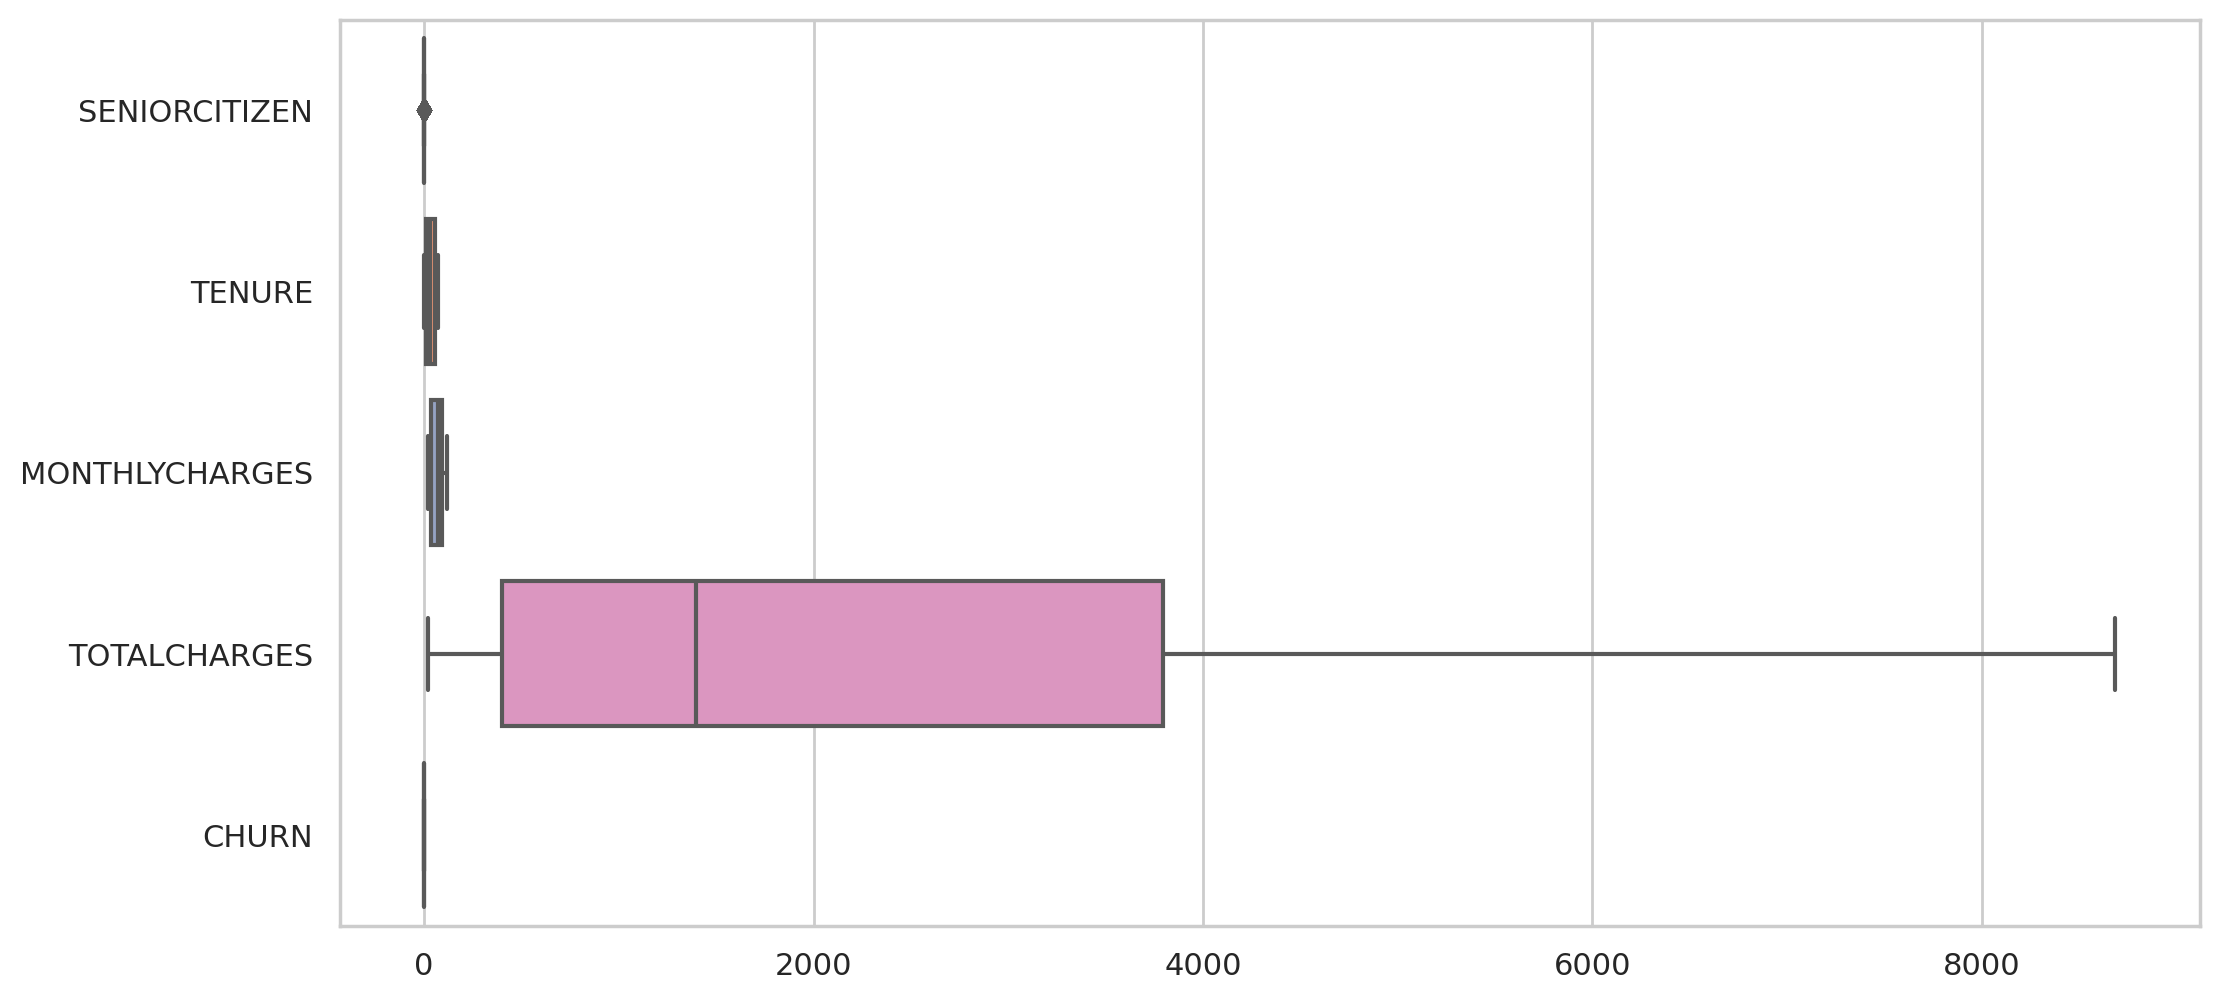

In [ ]:
# Outliner (Isolation Forest)
plt.figure(figsize=(12,6),dpi=200)
sns.set_theme(style="whitegrid")
sns.boxplot(data=df, orient="h", palette="Set2")
plt.show()

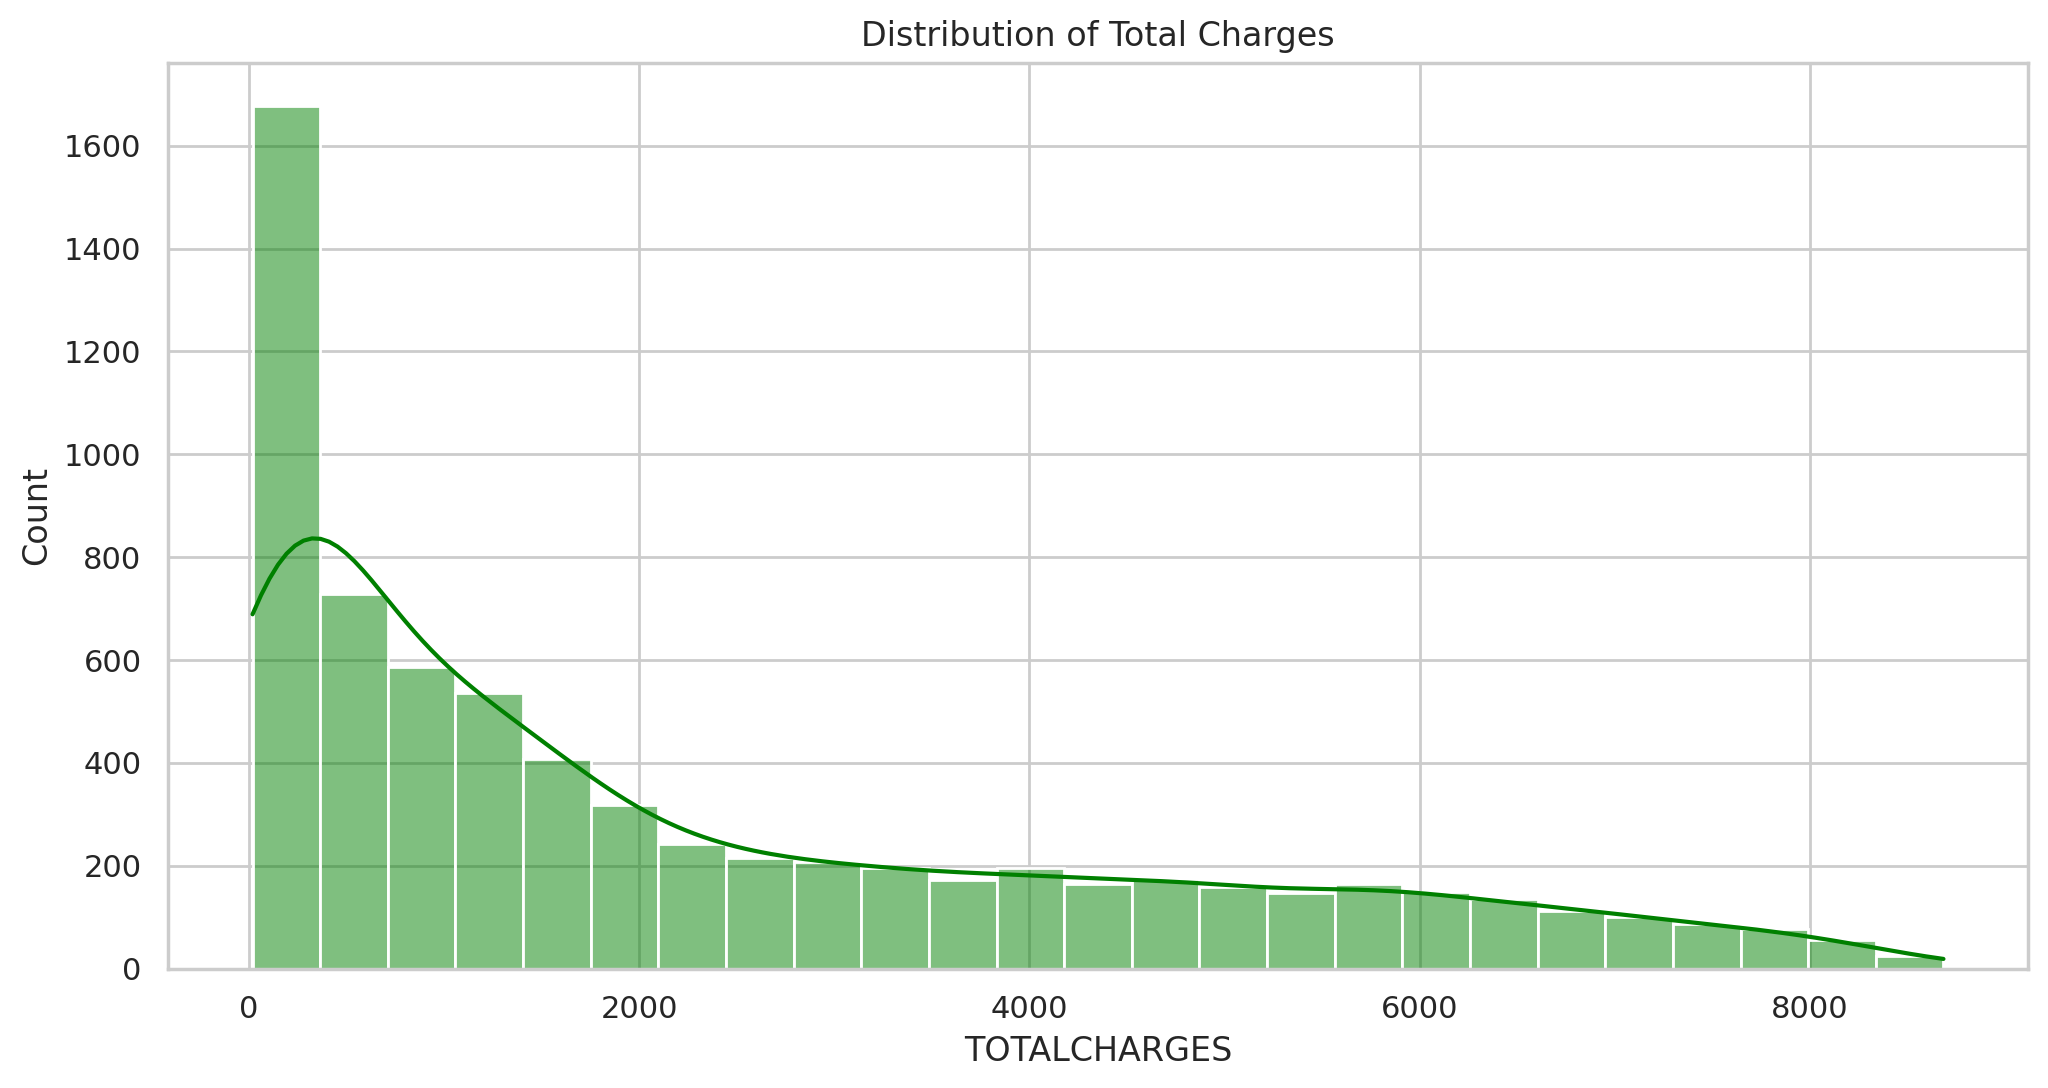

In [ ]:
plt.figure(figsize=(12,6),dpi=200)
sns.histplot(data=df,x="TOTALCHARGES",color="green",kde=True)
plt.title("Distribution of Total Charges")
plt.show()

In [ ]:
pd.DataFrame(df.TOTALCHARGES.value_counts()).head()

,TOTALCHARGES
20.20,11
19.75,9
19.65,8
20.05,8
19.90,8


In [ ]:
df["TOTALCHARGES"].isnull().values.any()

True

In [14]:
df["TOTALCHARGES"].fillna(df["TOTALCHARGES"].median(), inplace=True) 

In [15]:
model=IsolationForest(n_estimators=1000,max_samples='auto',contamination=float(0.2),max_features=1.0)
model.fit(df[['TOTALCHARGES']])

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


IsolationForest(contamination=0.2, n_estimators=1000)

In [16]:
df['scores']=model.decision_function(df[['TOTALCHARGES']])
df['anomaly']=model.predict(df[['TOTALCHARGES']])
df.tail(10)

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN,scores,anomaly
7033,9767-FFLEM,Male,0,No,No,38,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Credit card (automatic),69.50,2625.25,0,0.017372,1
7034,0639-TSIQW,Female,0,No,No,67,Yes,Yes,Fiber optic,Yes,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,1,-0.056482,-1
7035,8456-QDAVC,Male,0,No,No,19,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer (automatic),78.70,1495.10,0,0.047775,1
7036,7750-EYXWZ,Female,0,No,No,12,No,No phone service,DSL,No,Yes,Yes,Yes,Yes,Yes,One year,No,Electronic check,60.65,743.30,0,0.050575,1
7037,2569-WGERO,Female,0,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,0,0.053947,1
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,0,0.023297,1
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,0,-0.084250,-1
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,0.054415,1
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,1,0.058813,1
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.50,0,-0.053273,-1


In [17]:
df_anomaly = df[df['anomaly'] != -1]
df_anomaly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 0 to 7041
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   CUSTOMERID        5634 non-null   object 
 1   GENDER            5634 non-null   object 
 2   SENIORCITIZEN     5634 non-null   int64  
 3   PARTNER           5634 non-null   object 
 4   DEPENDENTS        5634 non-null   object 
 5   TENURE            5634 non-null   int64  
 6   PHONESERVICE      5634 non-null   object 
 7   MULTIPLELINES     5634 non-null   object 
 8   INTERNETSERVICE   5634 non-null   object 
 9   ONLINESECURITY    5634 non-null   object 
 10  ONLINEBACKUP      5634 non-null   object 
 11  DEVICEPROTECTION  5634 non-null   object 
 12  TECHSUPPORT       5634 non-null   object 
 13  STREAMINGTV       5634 non-null   object 
 14  STREAMINGMOVIES   5634 non-null   object 
 15  CONTRACT          5634 non-null   object 
 16  PAPERLESSBILLING  5634 non-null   object 


In [ ]:
df_anomaly.drop("scores",axis=1, inplace=True)

In [ ]:
df_anomaly.drop("anomaly",axis=1, inplace=True)

In [20]:
df_study=df_anomaly

Create New Variables

In [ ]:
df_study['NEW_TotalServices'] = (df_study[['PHONESERVICE', 'INTERNETSERVICE', 'ONLINESECURITY',
                                 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT',
                                 'STREAMINGTV', 'STREAMINGMOVIES']]== 'Yes').sum(axis=1)

In [ ]:
df_study["NEW_AVG_Service_Fee"] = df_study["MONTHLYCHARGES"] / (df_study['NEW_TotalServices'] + 1)

In [31]:
#Label encoder
def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

In [32]:
binary_cols = [col for col in df_study.columns if df_study[col].dtype == "O" and df_study[col].nunique() == 2]
binary_cols

['GENDER', 'PARTNER', 'DEPENDENTS', 'PHONESERVICE', 'PAPERLESSBILLING']

In [ ]:
for col in binary_cols:
    df_study = label_encoder(df_study, col)
df_study.head(2)

In [36]:
#One-hot encoding (>2)
ohe_cols = [col for col in df_study.columns if 10 >= df_study[col].nunique() > 2]  
ohe_cols

['MULTIPLELINES',
 'INTERNETSERVICE',
 'ONLINESECURITY',
 'ONLINEBACKUP',
 'DEVICEPROTECTION',
 'TECHSUPPORT',
 'STREAMINGTV',
 'STREAMINGMOVIES',
 'CONTRACT',
 'PAYMENTMETHOD',
 'NEW_TotalServices']

In [37]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=True):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

In [38]:
df_study = one_hot_encoder(df_study, ohe_cols)
df_study.head(2)

,CUSTOMERID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,PAPERLESSBILLING,MONTHLYCHARGES,TOTALCHARGES,CHURN,NEW_AVG_Service_Fee,MULTIPLELINES_No phone service,MULTIPLELINES_Yes,INTERNETSERVICE_Fiber optic,INTERNETSERVICE_No,ONLINESECURITY_No internet service,ONLINESECURITY_Yes,ONLINEBACKUP_No internet service,ONLINEBACKUP_Yes,DEVICEPROTECTION_No internet service,DEVICEPROTECTION_Yes,TECHSUPPORT_No internet service,TECHSUPPORT_Yes,STREAMINGTV_No internet service,STREAMINGTV_Yes,STREAMINGMOVIES_No internet service,STREAMINGMOVIES_Yes,CONTRACT_One year,CONTRACT_Two year,PAYMENTMETHOD_Credit card (automatic),PAYMENTMETHOD_Electronic check,PAYMENTMETHOD_Mailed check,NEW_TotalServices_1,NEW_TotalServices_2,NEW_TotalServices_3,NEW_TotalServices_4,NEW_TotalServices_5,NEW_TotalServices_6,NEW_TotalServices_7
0,7590-VHVEG,0,0,1,0,1,0,1,29.85,29.85,0,14.9250,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0
1,5575-GNVDE,1,0,0,0,34,1,0,56.95,1889.50,0,14.2375,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
# num variables
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES']

In [39]:
cat_cols, num_cols, cat_but_car = grab_col_names(df_study)  # Nümerik değişkenler
num_cols

['TENURE', 'MONTHLYCHARGES', 'TOTALCHARGES', 'NEW_AVG_Service_Fee']

In [40]:
scaler = StandardScaler()
df_study[num_cols] = scaler.fit_transform(df_study[num_cols])

In [41]:
df_study[num_cols].head()

,TENURE,MONTHLYCHARGES,TOTALCHARGES,NEW_AVG_Service_Fee
0,-1.131902,-0.968941,-1.045186,-0.320471
1,0.451502,0.004787,0.456800,-0.412062
2,-1.083920,-0.106599,-0.981946,-0.515309
3,0.979304,-0.521601,0.417426,-0.899991
4,-1.083920,0.498837,-0.946812,2.400611


#Build models

In [45]:
df_study.drop("CUSTOMERID", inplace=True, axis=1)

In [ ]:
y = df_study["CHURN"]
X = df_study.drop(["CHURN"], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3943, 38), (1691, 38), (3943,), (1691,))

Catboost Model

In [ ]:
catboost_model = CatBoostClassifier(verbose=False, random_state=42).fit(X_train, y_train)
y_pred = catboost_model.predict(X_test)

In [ ]:
def plot_feature_importance(importance,names,model_type):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data = {'feature_names': feature_names, 'feature_importance': feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(20, 18))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

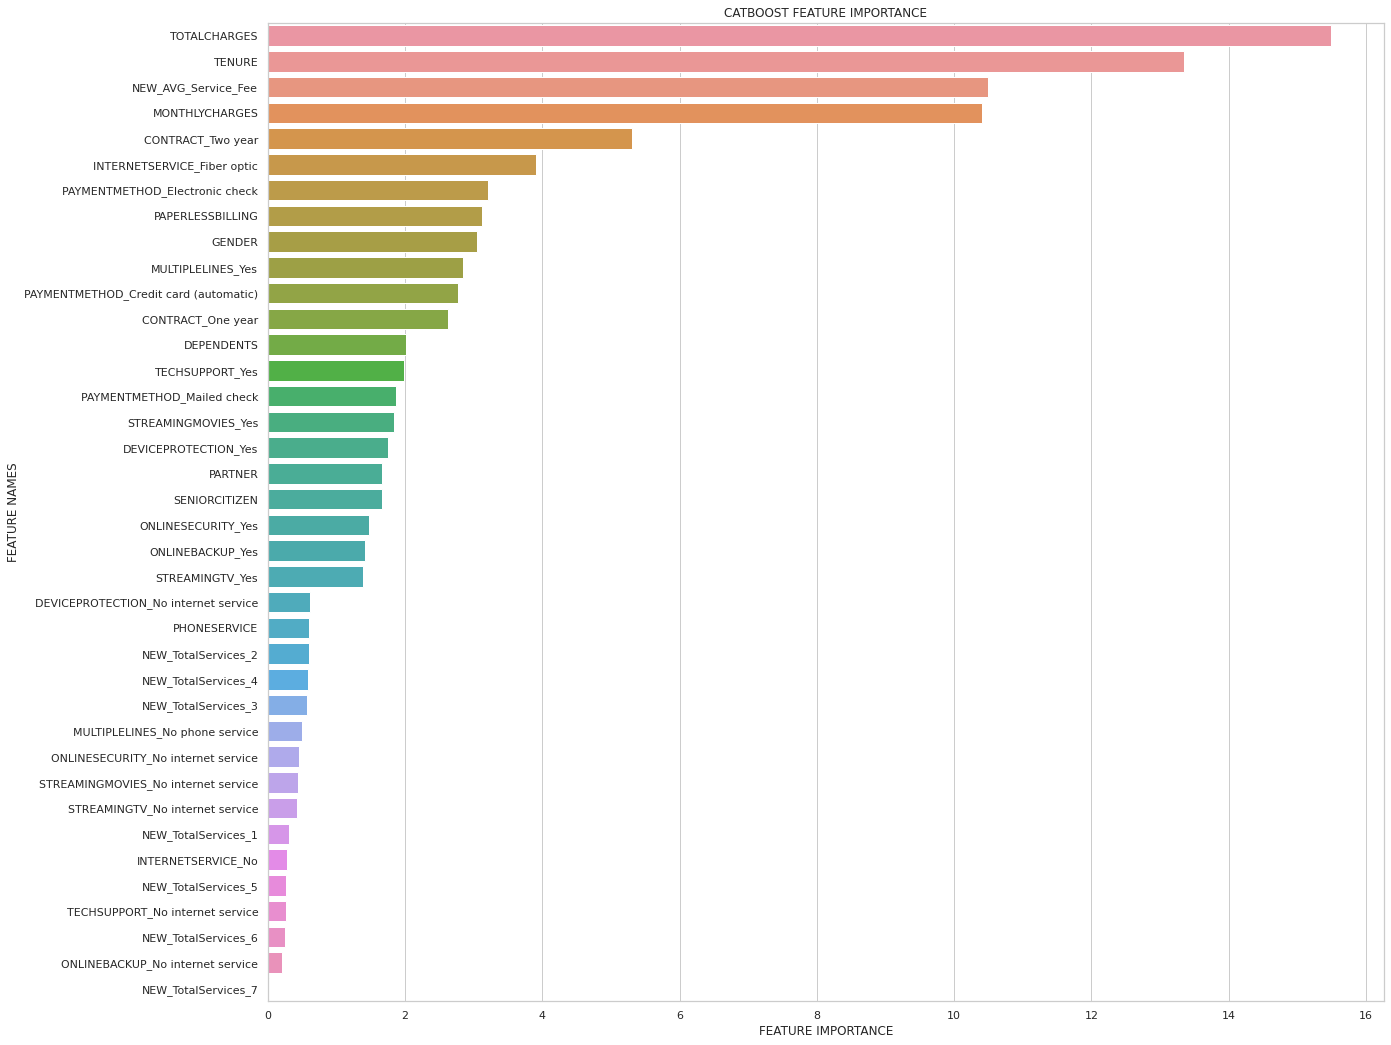

In [ ]:
plot_feature_importance(catboost_model.get_feature_importance(), X.columns, 'CATBOOST')

In [ ]:
X=X.iloc[:,[4,7,8,9,12,13,26,27]]

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 0 to 7041
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TENURE                       5634 non-null   float64
 1   MONTHLYCHARGES               5634 non-null   float64
 2   TOTALCHARGES                 5634 non-null   float64
 3   NEW_AVG_Service_Fee          5634 non-null   float64
 4   INTERNETSERVICE_Fiber optic  5634 non-null   uint8  
 5   INTERNETSERVICE_No           5634 non-null   uint8  
 6   CONTRACT_One year            5634 non-null   uint8  
 7   CONTRACT_Two year            5634 non-null   uint8  
dtypes: float64(4), uint8(4)
memory usage: 242.1 KB


 Making ANN

In [93]:
# Importing Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, Dropout

In [ ]:
le =  LabelEncoder()
y_le = le.fit_transform(y) 
y_le

array([0, 0, 1, ..., 0, 0, 1])

In [ ]:
#target into one hot encoding
y_ohe = pd.get_dummies(y_le).values
y_ohe

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.30, random_state=17)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3943, 8), (1691, 8), (3943, 2), (1691, 2))

In [ ]:
model = Sequential()

model.add(layers.Dense(19, activation="relu", name="layer1",input_shape=(38,)))
model.add(layers.Dense(19, activation="relu", name="layer2"))
model.add(layers.Dense(2, activation="softmax", name="outputs"))

In [ ]:
# Adam optimizer with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, verbose=1, batch_size=5, epochs=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
789/789 [==============================] - 4s 4ms/step - loss: 0.5314 - accuracy: 0.7190
Epoch 2/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4439 - accuracy: 0.7768
Epoch 3/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4398 - accuracy: 0.7763
Epoch 4/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4388 - accuracy: 0.7804
Epoch 5/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4370 - accuracy: 0.7839
Epoch 6/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4371 - accuracy: 0.7844
Epoch 7/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4357 - accuracy: 0.7867
Epoch 8/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4357 - accuracy: 0.7847
Epoch 9/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4350 - accuracy: 0.7834
Epoch 10/50
789/789 [==============================] - 3s 4ms/step - loss: 0.4352 - accuracy: 0.7862

In [ ]:
results = model.evaluate(X_test, y_test)

print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

53/53 [==============================] - 0s 3ms/step - loss: 0.4627 - accuracy: 0.7540
Final test set loss: 0.462720
Final test set accuracy: 0.753992


In [ ]:
#Predict test data
pred_y = model.predict(X_test)
pred_y

array([[0.9908358 , 0.00916416],
       [0.5785883 , 0.42141166],
       [0.46984962, 0.53015035],
       ...,
       [0.6394505 , 0.36054957],
       [0.97996855, 0.02003142],
       [0.2589148 , 0.74108523]], dtype=float32)

In [ ]:
# Actual and predicted value
actual = np.argmax(y_test,axis=1)
predicted = np.argmax(pred_y,axis=1)
print(f"Actual: {actual}")
print(f"Predicted: {predicted}")

Actual: [0 1 0 ... 0 0 1]
Predicted: [0 0 1 ... 0 0 1]


In [ ]:
cm = confusion_matrix(actual,predicted)
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      1169
           1       0.66      0.41      0.51       522

    accuracy                           0.75      1691
   macro avg       0.72      0.66      0.67      1691
weighted avg       0.74      0.75      0.73      1691



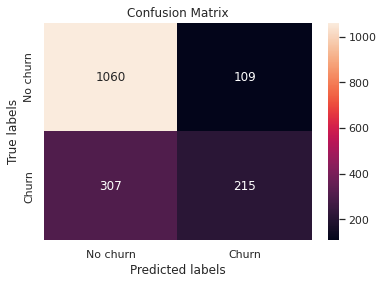

In [ ]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No churn', 'Churn']); ax.yaxis.set_ticklabels(['No churn', 'Churn']);

In [ ]:
# Initialising the ANN
classifier = Sequential()

In [ ]:
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu', input_dim = 38))

# Adding the second hidden layer
classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu'))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN | means applying SGD on the whole ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
# Fitting the ANN to the Training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

In [ ]:
score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)

395/395 [==============================] - 2s 4ms/step - loss: 0.3595 - accuracy: 0.8313
Train score: 0.3595401346683502
Train accuracy: 0.8313466906547546


In [ ]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

In [ ]:
print('*'*20)
score, acc = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

********************
170/170 [==============================] - 1s 3ms/step - loss: 0.4930 - accuracy: 0.7664
Test score: 0.4929884970188141
Test accuracy: 0.7664104104042053


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

Text(0.5, 12.5, 'Predicted label')

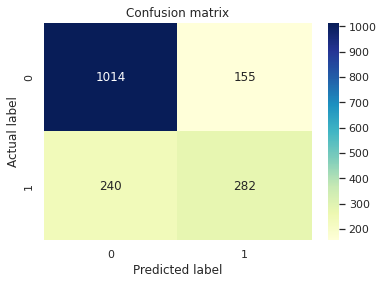

In [ ]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
#import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1169
           1       0.65      0.54      0.59       522

    accuracy                           0.77      1691
   macro avg       0.73      0.70      0.71      1691
weighted avg       0.76      0.77      0.76      1691



In [ ]:
# Evaluation of Multiple Training Instances
# Evaluating the ANN
from keras.wrappers.scikit_learn import KerasClassifier

def build_classifier():
    classifier = Sequential()
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu', input_dim = 38))
    classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu'))
    classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))
    classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return classifier
classifier = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100,verbose=0)
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
mean = accuracies.mean()
variance = accuracies.std()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  if sys.path[0] == '':


In [ ]:
print('Mean accuracy score of 10 different models using Kfold cross validation: {}'.format(mean))
print('Standard Deviation of accuracy score of 10 different models using Kfold cross validation: {}'.format(variance))

Mean accuracy score of 10 different models using Kfold cross validation: 0.7778448820114136
Standard Deviation of accuracy score of 10 different models using Kfold cross validation: 0.01798946513150859


In [ ]:
#Overfitting problem
from keras.layers import Dropout
classifier = Sequential()
# Adding the input layer and the first hidden layer
classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu', input_dim = 38))
classifier.add(Dropout(rate = 0.1))

# Adding the second hidden layer
classifier.add(Dense(units = 19, kernel_initializer = 'uniform', activation = 'relu'))
classifier.add(Dropout(rate = 0.1))

# Adding the output layer
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))

# Compiling the ANN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Fitting the ANN to the Training set
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100,verbose = 0)

# Part 3 - Making predictions and evaluating the model

score, acc = classifier.evaluate(X_train, y_train,
                            batch_size=10)
print('Train score:', score)
print('Train accuracy:', acc)
# Part 3 - Making predictions and evaluating the model

# Predicting the Test set results
y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

print('*'*20)
score, acc = classifier.evaluate(X_test, y_test,
                            batch_size=10)
print('Test score:', score)
print('Test accuracy:', acc)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

395/395 [==============================] - 1s 3ms/step - loss: 0.3580 - accuracy: 0.8400
Train score: 0.3579547703266144
Train accuracy: 0.8399695754051208
********************
170/170 [==============================] - 1s 3ms/step - loss: 0.4778 - accuracy: 0.7694
Test score: 0.4778064489364624
Test accuracy: 0.7693672180175781


Text(0.5, 12.5, 'Predicted label')

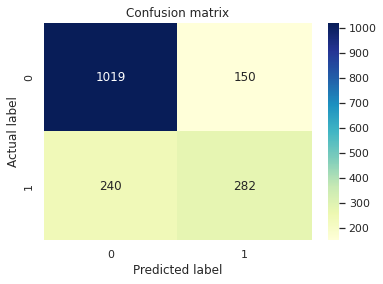

In [ ]:
p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# IMBALANCED DATA

In [71]:
# class count
class_count_0, class_count_1 = df_study['CHURN'].value_counts()

# Separate class
class_0 = df_study[df_study['CHURN'] == 0]
class_1 = df_study[df_study['CHURN'] == 1]# print the shape of the class
print('class 0:', class_0.shape)
print('class 1:', class_1.shape)

class 0: (3965, 39)
class 1: (1669, 39)


# Random Under Sampling

total class of 1 and0: 1    1669
0    1669
Name: CHURN, dtype: int64


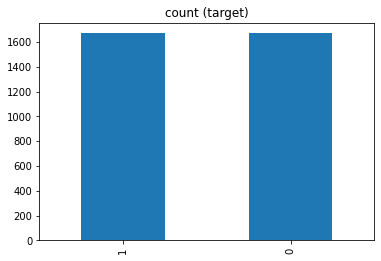

In [72]:
class_0_under = class_0.sample(class_count_1)

test_under = pd.concat([class_0_under, class_1], axis=0)

print("total class of 1 and0:",test_under['CHURN'].value_counts())# plot the count after under-sampeling
test_under['CHURN'].value_counts().plot(kind='bar', title='count (target)')

In [73]:
test_under.shape

(3338, 39)

#Alternative Sampling

In [74]:
y = df_study["CHURN"]
X = df_study.drop(["CHURN"], axis=1)

In [56]:
import imblearn

In [75]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable
x_rus, y_rus = rus.fit_resample(X, y)

In [76]:
y_rus=pd.DataFrame(y_rus)

In [77]:
x_rus=pd.DataFrame(x_rus)

In [79]:
y_rus.shape

(3338, 1)

In [80]:
y_rus['CHURN'].value_counts()

1    1669
0    1669
Name: CHURN, dtype: int64

In [ ]:
test_under2 = pd.concat([x_rus, y_rus], axis=1)
test_under2.info()

In [86]:
test_under2['CHURN'].value_counts()

1    1669
0    1669
Name: CHURN, dtype: int64

In [88]:
test_under2.shape

(3338, 39)

#Build Model

In [90]:
y = test_under2["CHURN"]
X = test_under2.drop(["CHURN"], axis=1)

In [92]:
X=X.iloc[:,[4,7,8,9,12,13,26,27]]

In [94]:
le =  LabelEncoder()
y_le = le.fit_transform(y) 
y_le

array([0, 0, 0, ..., 1, 1, 1])

In [95]:
#target into one hot encoding
y_ohe = pd.get_dummies(y_le).values
y_ohe

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [0, 1],
       [0, 1]], dtype=uint8)

In [97]:
# Split the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=0.30, random_state=17)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2336, 8), (1002, 8), (2336, 2), (1002, 2))

In [98]:
model = Sequential()

model.add(layers.Dense(4, activation="relu", name="layer1",input_shape=(8,)))
model.add(layers.Dense(4, activation="relu", name="layer2"))
model.add(layers.Dense(2, activation="softmax", name="outputs"))

In [99]:
# Adam optimizer with learning rate of 0.001
optimizer = Adam(lr=0.001)
model.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, verbose=1, batch_size=5, epochs=50)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
468/468 [==============================] - 4s 3ms/step - loss: 0.6573 - accuracy: 0.6199
Epoch 2/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5841 - accuracy: 0.7277
Epoch 3/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5502 - accuracy: 0.7359
Epoch 4/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5351 - accuracy: 0.7453
Epoch 5/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5282 - accuracy: 0.7491
Epoch 6/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5236 - accuracy: 0.7470
Epoch 7/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5206 - accuracy: 0.7457
Epoch 8/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5168 - accuracy: 0.7474
Epoch 9/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5143 - accuracy: 0.7504
Epoch 10/50
468/468 [==============================] - 1s 3ms/step - loss: 0.5111 - accuracy: 0.7483

In [100]:
results = model.evaluate(X_test, y_test)

print('Final test set loss: {:4f}'.format(results[0]))
print('Final test set accuracy: {:4f}'.format(results[1]))

32/32 [==============================] - 0s 3ms/step - loss: 0.4865 - accuracy: 0.7525
Final test set loss: 0.486466
Final test set accuracy: 0.752495


In [101]:
#Predict test data
pred_y = model.predict(X_test)
pred_y

array([[0.24221551, 0.7577844 ],
       [0.9045443 , 0.0954557 ],
       [0.17087036, 0.82912964],
       ...,
       [0.23211543, 0.7678846 ],
       [0.52935725, 0.47064272],
       [0.12882324, 0.8711768 ]], dtype=float32)

In [102]:
# Actual and predicted value
actual = np.argmax(y_test,axis=1)
predicted = np.argmax(pred_y,axis=1)
print(f"Actual: {actual}")
print(f"Predicted: {predicted}")

Actual: [1 0 1 ... 1 1 0]
Predicted: [1 0 1 ... 1 0 1]


In [103]:
cm = confusion_matrix(actual,predicted)
print(classification_report(actual,predicted))

              precision    recall  f1-score   support

           0       0.77      0.72      0.74       501
           1       0.74      0.79      0.76       501

    accuracy                           0.75      1002
   macro avg       0.75      0.75      0.75      1002
weighted avg       0.75      0.75      0.75      1002



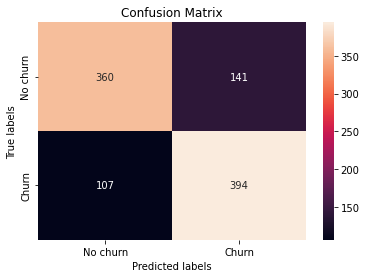

In [104]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No churn', 'Churn']); ax.yaxis.set_ticklabels(['No churn', 'Churn']);